# Fruit Classifier

What if we were building a model to classify fruits, say to decide if a particular fruit is good or rotten.

That was the question that got asked in one of the 1:1 this week.

I built this model to show how this could be done using a Convolutional Neural Network, not dissimilar to the one that we built for project one.

The major difference is that Projet 1 is a ** regression exercise **, i.e. it returns 68 x,y pairs of where the keypoints are, whilst this exercise returns wheter a fruit is good or rotten (i.e if it belongs to a specific class).

As we are dealing with two classes, this is a ** binary ** classifier

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

## Reloading last saved set of weights

I have already trained this model, and saved the weights in **saved_models/best_ever.pt**

In [2]:
# !conda install opencv -y

## A few helpers

The functions below are used to help extract data from the **/data** folder and identify the class that the image belogs to.

I use the name of the folder itself as the name of the class

This is different from P1_Facial_Keypoints - as the training data in that exercise contains a set of keypoints - and in this exercise we have two folders for training: one with good fruits and one with rotten fruits

In [3]:
import glob
import os

# extract class name from the class folder
def getFolderClass(str):
    parts = str.split('/')
    return parts[-1]

# extract class name from a file name
def getFileClass(str):
    parts = str.split('/')
    return parts[-2]

def extractClassNames(folder):
    class_folders = glob.glob(os.path.join(folder,'*'))
    class_names = [ getFolderClass(f) for f in class_folders ]
    
    newdict = {}
    translator = {}
    for i,c in enumerate(class_names):
        newdict[c] = i
        translator[i] = c
    
    return newdict,translator
     

In [4]:
## testing the helper for classes
print(extractClassNames('data/training'))

({'bad_berries': 0, 'good_berries': 1}, {0: 'bad_berries', 1: 'good_berries'})


## Look at one of the images

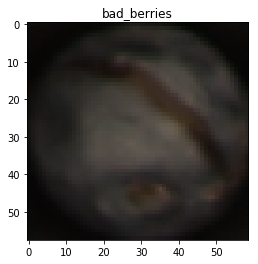

In [5]:
# a quick look at one of the loaded images

import matplotlib.image as mpimg
import random

files = glob.glob(os.path.join('data/training','*/*'))

image_file_name = files[random.randint(800,1000)]

image = mpimg.imread(image_file_name)

plt.title(getFileClass(image_file_name))
plt.imshow(image)

## Defining the Dataset

It is similar to the original dataset, with the differences that:
* It returns image and class
* it retains the color channel


## We will work in a different way

We will load the whole dataset at once

In [6]:
import glob
import os
import numpy as np

import cv2



In [7]:
# this works for both
all_classes, classes_dict = extractClassNames('data/training')
print(all_classes)

{'bad_berries': 0, 'good_berries': 1}


In [8]:
def rescale(image,output_size):
        
        h, w = image.shape[:2]

        if isinstance(output_size, int):
            if h > w:
                new_h, new_w = output_size * h / w, output_size
            else:
                new_h, new_w = output_size, output_size * w / h
        else:
            new_h, new_w = output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        return img

def load_data(root_dir):
    """Fruits"""

    images = []
    classes = []

    # all files that need to be loaded
    files = glob.glob(os.path.join(root_dir,'*/*'))

    for image_file_name in files:
        image = mpimg.imread(image_file_name)
        
         
        label = getFileClass(image_file_name)
        img_class = all_classes[label] # read dict with class 
        images.append(rescale(image,(80,80)))
        classes.append(img_class)
        
    return np.array(images), np.array(classes)

In [9]:
train_images, train_labels = load_data('data/training/')
print(train_images.shape)

(2215, 80, 80, 3)


In [10]:
test_images, test_labels = load_data('data/test/')
print(test_images.shape)

(40, 80, 80, 3)


In [11]:
# Showing one image

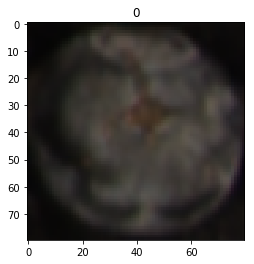

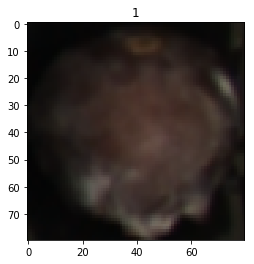

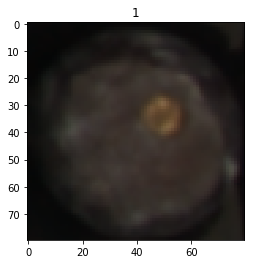

In [12]:
# a random number

for _ in range(3):
    i = random.randint(0,len(test_images) - 1)

      # get the image from its wrapper

    plt.title('{}'.format(test_labels[i]))
    plt.imshow(test_images[i])
    plt.show()

# Define the model

In [36]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.optimizers import RMSprop



In [37]:


model = Sequential()
model.add(Conv2D(filters=16, kernel_size=5, padding='same', activation='relu', 
                        input_shape=(80, 80, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))

model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 80, 80, 16)        1216      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 38, 38, 32)        4640      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 19, 19, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 9, 9, 128)         73856     
__________

# loss and Optimization

In [39]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### Defining the loss and optimization

We must choose a loss that works well with binary classification

We have a little more freedom in selecting the optimizer

In [ ]:
from keras.callbacks import ModelCheckpoint  

epochs = 4

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.hdf5', 
                               verbose=1,  save_best_only=True)

history = model.fit(train_images, train_labels, validation_split=0.20,
          epochs=epochs, batch_size=10, callbacks=[checkpointer], verbose=1)


Train on 1772 samples, validate on 443 samples
Epoch 1/4
1772/1772 [==============================] - 48s 27ms/step - loss: 0.6506 - acc: 0.6569 - val_loss: 1.0631 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.06309, saving model to saved_models/weights.best.hdf5
Epoch 2/4
1772/1772 [==============================] - 55s 31ms/step - loss: 0.6506 - acc: 0.6569 - val_loss: 1.0029 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 1.06309 to 1.00292, saving model to saved_models/weights.best.hdf5
Epoch 3/4
1030/1772 [================>.............] - ETA: 17s - loss: 0.6525 - acc: 0.6447

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

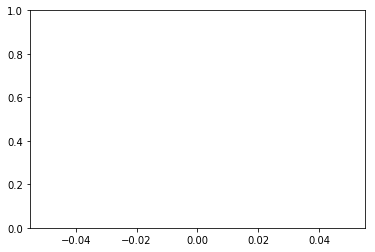

In [33]:
plt.plot(history.history['acc'], '-')
plt.plot(history.history['loss'], '-')
plt.ylim(0, 1) 
plt.show()

In [29]:
for metric,value in zip(model.metrics_names,history.history):
    print('{} -> {}'.format(metric,value[metric]) )

TypeError: string indices must be integers

In [34]:
print(history.history)

{'val_loss': [1.2585941854502762], 'val_acc': [0.12415350105773246], 'loss': [0.4910045294742821], 'acc': [0.7426636559094048]}


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [21]:
result = model.evaluate(test_images,test_labels)

40/40 [==============================] - 0s 6ms/step


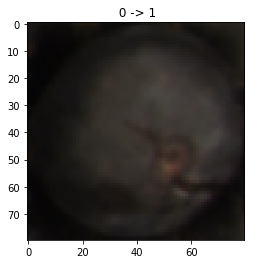

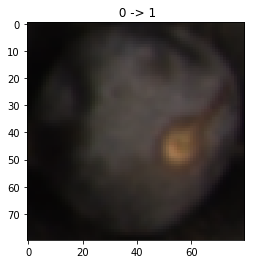

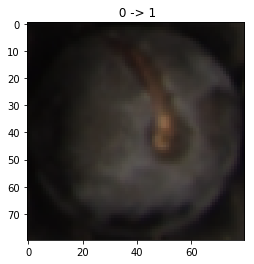

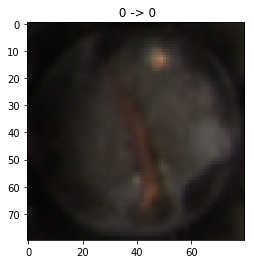

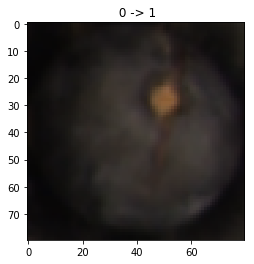

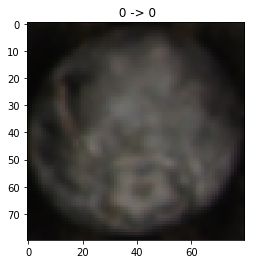

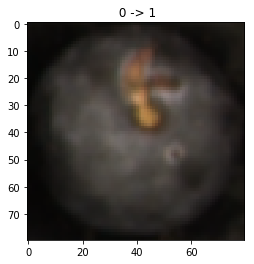

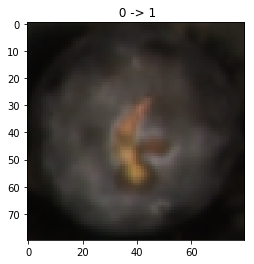

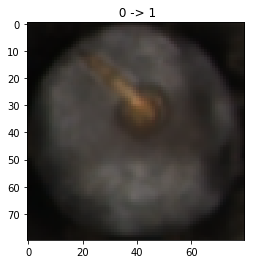

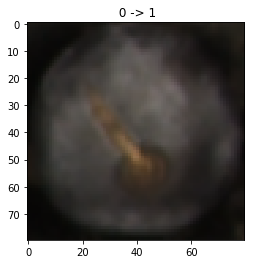

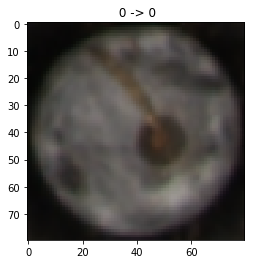

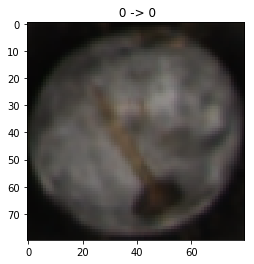

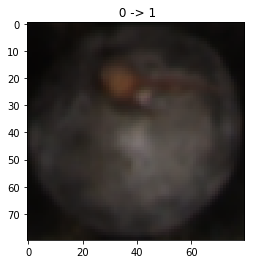

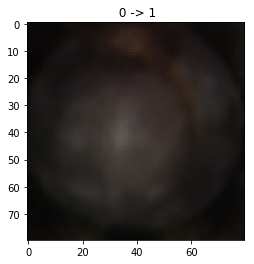

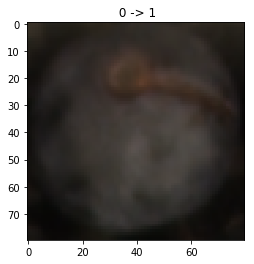

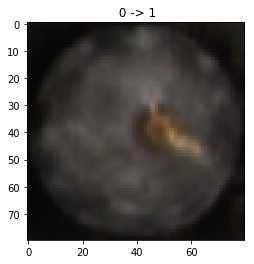

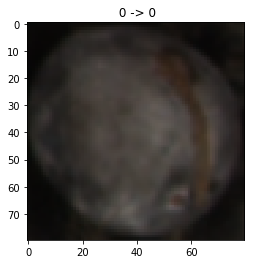

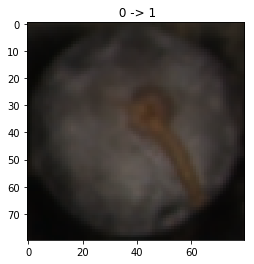

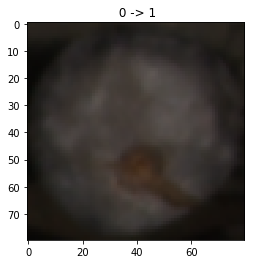

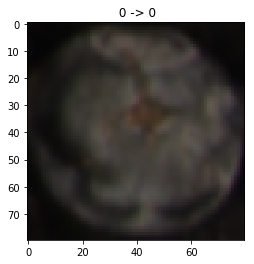

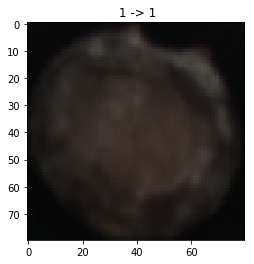

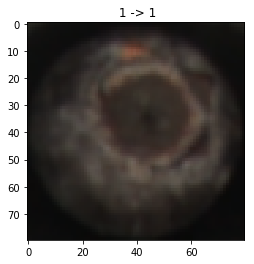

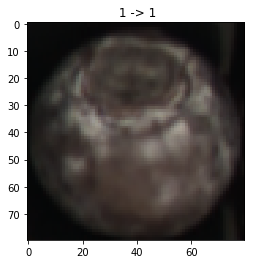

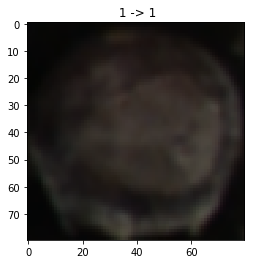

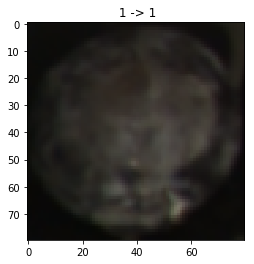

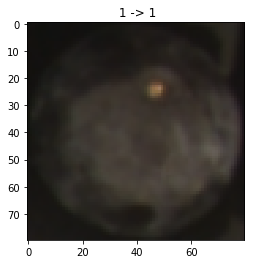

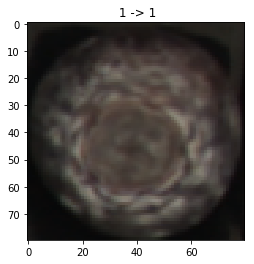

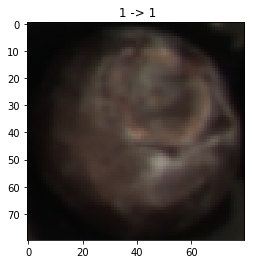

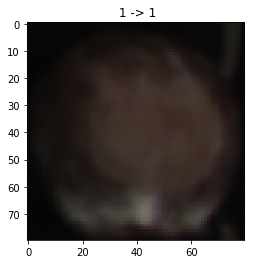

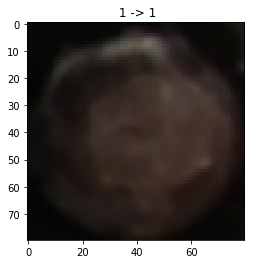

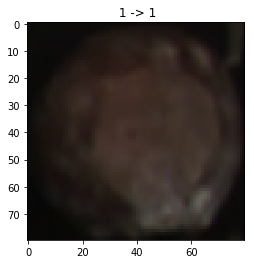

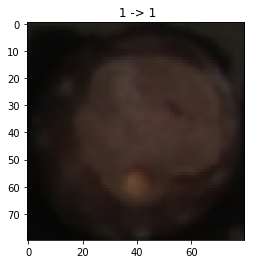

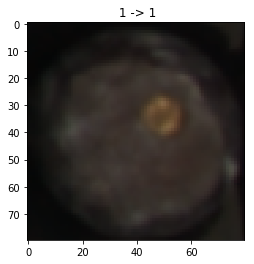

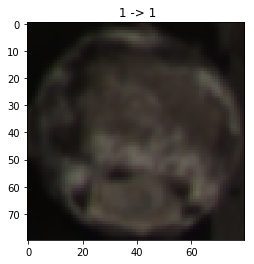

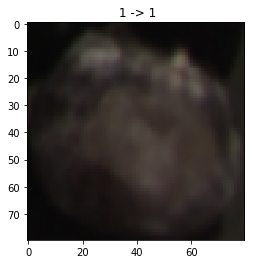

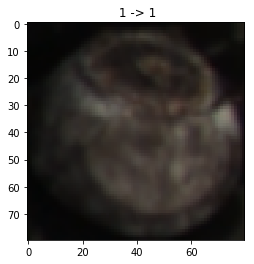

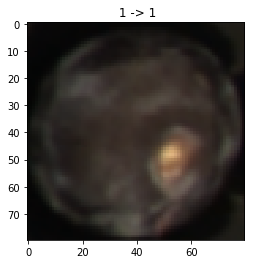

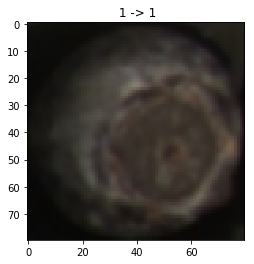

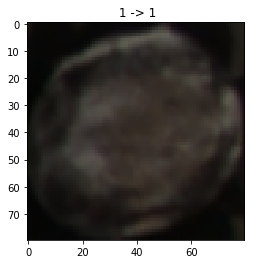

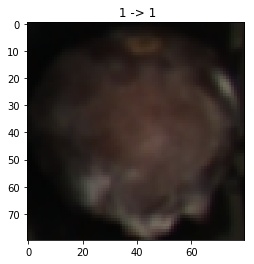

accuracy = 65.0 


In [112]:
no_rights = 0
no_imgs = 0

for image, label in zip(test_images,test_labels):
 
    result = model.predict(image.reshape(1,80,80,3))
    p_label = 1 if result[0][0] > .5 else 0
    
    no_imgs += 1
    no_rights += 1 if label == p_label else 0
    
    plt.title(' {} -> {}'.format(label,p_label))
    plt.imshow(image)
    plt.show()
    
print('accuracy = {} '.format(no_rights/no_imgs * 100))
    